<!--<h1 style="font-size:40px; font-family:Verdana" align="center"> UDS-Club Workshop </h1> -->
<h2 style="font-size:30px; font-family:Verdana" align="center"> Nonlinear Algorithms: Tree-based and Gradient Boosting Models </h2>
<img src='http://i.piccy.info/i9/666d78be04fbcf04fdb321d5953d1fa5/1492256847/123248/1137898/ua_parrots.jpg'/>
<h4 style="font-size:16px; font-family:Verdana" align="right"> by Valentina Deshko <br> <pre>    2017-04-23</pre> </h4>

# Table of Contents

[1. Tree-based Models](##Tree-based-Models)  
[Intro to the tree-based algorithms](#Intro-to-the-tree-based-algorithms)  
[Constructing the decision tree](#Constructing-the-decision-tree)  
[Random Forest (brief overview)](#Random-Forest-(brief-overview))  
[Extremely Randomize Trees](#Extremely-Randomize-Trees)  
[2. Gradient Boosting Algorithms](#Gradient-Boosting-Algorithms)  
[How does boosting work](#How-does-boosting-work)  
[Understanding of LightGBm parameters](#Understanding-of-LightGBm-parameters)   
[Understanding of XGBoost parameters](#Understanding-of-XGBoost-parameters)   
[General approach for parameters tuning](#General-approach-for-parameters-tuning) 


## 1. Tree-based Models 

## Intro to the tree-based algorithms

Decision tree is one of the most popular supervised machine learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. Tree models where the target variable can take a finite set of values are called classification trees. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

There are many specific decision-tree algorithms. Notable ones include:
 - ID3 (Iterative Dichotomiser 3)
 - C4.5 (successor of ID3)
 - CART (Classification And Regression Tree)

Scikit Learn uses an optimised version of the CART (Classification and Regression Trees) algorithm, that is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node. <br> Let us consider how we can build a decision tree using our data.

In [1]:
#import libraries

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import re, nltk
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn import  metrics, ensemble
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
%matplotlib inline


In [2]:
#train data
data = pd.read_csv("../data/movie_reviews.csv", sep=",")
# test data
test_data = pd.read_csv("../data/test.csv", sep=",")

In [3]:
#tokenize data
def tokenize(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    word_list = nltk.word_tokenize(text)
    stemmer = SnowballStemmer("english")
    stems = [stemmer.stem(word) for word in word_list]
    return stems

In [4]:
# split data on train and test 
X_train, X_test, y_train, y_test  = train_test_split(
        data.text, 
        data.label,
        test_size=0.1, 
        random_state=42)

In [7]:
#buid a classifier
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=17)
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 3),
                              analyzer = 'word', binary = True, max_df = 0.75, vocabulary=None)

#make a pipeline and fit the model
pipeline = Pipeline([('vectorizer', vectorizer), 
                     ('classifier', clf_tree)])
model = pipeline.fit(X=X_train, y=y_train)

Wall time: 6min 9s


In [7]:
#validation accuracy
y_pred = model.predict(X_test)
print ("Validation Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score_neg: ", f1_score(y_test, y_pred, pos_label = 0))

Validation Accuracy:  0.642225280126
F1 score_neg:  0.31234256927


In [37]:
#tree visualization (don't forget to install pydot library before)

export_graphviz(pipeline.named_steps['classifier'], 
out_file='sentiment_tree.dot', filled=True)

#transform our picture from .dot to .png format
!dot -Tpng sentiment_tree.dot -o ../small_tree.png

<a href="http://piccy.info/view3/11093446/0264747ab85fba81e151d28967820cd0/" target="_blank"><img src="http://i.piccy.info/i9/18234d3aac91cc89c6680134b321d6d7/1492623923/49692/1138985/small_tree1.png" alt="Piccy.info - Free Image Hosting" border="0" /></a><a href="http://i.piccy.info/a3c/2017-04-19-17-45/i9-11093446/786x359-r" target="_blank"><img src="http://i.piccy.info/a3/2017-04-19-17-45/i9-11093446/786x359-r/i.gif" alt="" border="0" /></a>


We can see which term were choosen to split our data in nodes. <br>
[To the table of contents](#Table-of-Contents)


## Constructing the decision tree

So, we can say that decision tree is a simple flowchart that selects labels for target values.
This flowchart consists of decision nodes, which check feature values, and leaf nodes, which assign labels. To choose the label for target value, we begin at the flowchart's initial decision node, known as its root node. 

Decision trees are formed by a collection of rules based on features in the modeling data set:

* Rules based on features' values are selected to get the best split to differentiate observations based on the dependent/target variable<br/>
* Once a rule is selected and splits a node into two, the same process is applied to each "child" node (i.e. it is a recursive procedure)<br/>
* Splitting stops when CART detects no further gain can be made, or some pre-set stopping rules are met. (Alternatively, the data are split as much as possible and then the tree is later pruned)<br/>
* Each branch of the tree ends in a terminal node. Each observation falls into one and exactly one terminal node, and each terminal node is uniquely defined by a set of rules.




Feature, that is selected to get the best split intuitively corresponds to the idea of information gain based on entropy. 
The Shannon entropy (named after Claude Shannon, the "father of information theory") for a system with N possible states is defined as follows:
$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i$$

where p - probability of each label;


Let's  calculate entropy for our root node and make sure that we get the same result as on our plot.

In [14]:
from math import log
S = - 56629/137349*log(56629/137349, 2) - 80720/137349*log(80720/137349, 2)
print(S)

0.9776924394570736


By itself this value doesn't say a lot to us. So, lets split our data and calculate an Information Gain (which is the difference between the entropies before and after split)

$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$

N_i - subset of N, which has value i;<br>
q - number of nodes.

### Task1 
please add the required data and calculate Information Gain after the decision tree' first split on our plot using the formula above.

In [ ]:
IG = S - N1/137349*S1 - N2/137349*S2

<details>
  <summary>Click to see answer</summary>
      <pre>
          <code>
              IG = 0.03             
          </code>
      </pre>
</details>

### Main parameters:
* max_depth – the maximum depth of the tree;
* max_features - the number of features to consider when looking for the best split;
* min_samples_leaf – the minimum number of samples required to split an internal node.<br>
You can use cross-validation to tune model hyperparameters.

  ### Decision Trees Pros
* Simple to understand and to interpret (uses a white box model). Trees can be visualised.
* Requires little data preparation.
* Able to handle both numerical and categorical data.
* Fast training 

### Decision Trees Cons
* Decision-tree learners can create over-complex trees that do not generalise the data well (overfitting).
* Can be unstable because small variations in the data might result in a completely different tree being generated.
* Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree. <br>

[To the table of contents](#Table-of-Contents)

## Ensemble Algorithms: Random Forest and Extra Trees

But what should we do if we can not improve model accuracy using only one algorithm? We should try more advanced machine learning techniques called "ensembles". 
Simply put we can say that ensemble is predictions' aggregation of several basic algorithms aiming higher accuracy. <br>

Lets start learning ensemble algorithms with notion of Bagging.<br>
A Bagging is an ensemble meta-estimator that fits base classifiers/regressors each on random subsets of the original dataset and then aggregate their individual predictions (in classification case by voting, in regression case by averaging) to form a final prediction.

<img src="http://i.piccy.info/i9/293f6705e969ef92944f31c6c08ae1c6/1492767761/123500/1138985/bagging.png"/>

### Random Forest (brief overview)

Random Forest is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees (decision trees that are grown very deep tend to learn highly irregular patterns: they overfit their training sets, i.e. have low bias, but very high variance. Random forests are a way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance).
Random decision forests correct for decision trees' habit of overfitting to their training set. <br> 

So we can say that Random Forest is like bootstrapping algorithm with Decision tree (CART) model. Random forests differ in only one way from this general scheme: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. This process is called random subspace method or sometimes "feature bagging", and it attempts to reduce the correlation between estimators (decision trees) in an ensemble by training them on random samples of features instead of the entire feature set. <br> 


In [7]:
# RF code and example

rf_classifier = RandomForestClassifier(n_estimators = 50, min_samples_leaf=3, n_jobs = -1,
                                       random_state = 17)

vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 3),
                              analyzer = 'word', binary = True, max_df = 0.75, vocabulary=None)

pipeline = Pipeline([('vectorizer', vectorizer), 
                     ('classifier', rf_classifier)])
model = pipeline.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)

print ("Validation Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score_neg: ", f1_score(y_test, y_pred, pos_label = 0))

Validation Accuracy:  0.745298473232
F1 score_neg:  0.612191958495


In [8]:
y_pred_test = model.predict(test_data.text)
print ("Test Accuracy: ", accuracy_score(test_data.label, y_pred_test))
print("F1 score_neg: ", f1_score(test_data.label, y_pred_test, pos_label = 0))

print(classification_report(test_data.label, y_pred_test))

Test Accuracy:  0.63339587242
F1 score_neg:  0.444412851862
             precision    recall  f1-score   support

          0       0.92      0.29      0.44      5330
          1       0.58      0.97      0.73      5330

avg / total       0.75      0.63      0.59     10660



Main parameters:
* n_estimators — the number of trees in the forest (by default=10);
* max_features — the number of features to consider when looking for the best split;
* criterion — the function to measure the quality of a split ('mse' for regression, gini' or 'entropy' for classification);
* min_samples_leaf — the minimum number of samples required to be at a leaf node;
* max_depth — the maximum depth of the tree.

You could find more information about Randon Forest (and other ensembles) parameters [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).

### Random Forest Pros:
* it is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier;
* runs efficiently on large databases;
* gives estimates of what variables are important in the classification;
* has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing;
* has methods for balancing error in class population unbalanced data sets;

### Random Forest Cons:
* produces a lower accurary on 'sparse' data (e.g. text, bag of words, sparse matrix);
* can be overfitted for some datasets with noisy classification/regression tasks;
* difficult to interpret.

[To the table of contents](#Table-of-Contents)

### Extremely Randomize Trees

or Extra Trees are very similar to Random Forest algorithm, but use differenrt approach to constructing the decion trees:

* each tree is built from the complete learning sample (doesn't apply the bagging procedure to construct a set of the training samples for each tree);
* for each of the features (randomly selected at each interior node) a discretization threshold (cut-point) is selected at random to define a split, instead of choosing the best cut-point based on the local sample (as in Tree Bagging or in the Random Forests methods).

In [41]:
# Extra Tree Classifier
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=50, 
                             max_leaf_nodes=None, 
                             min_samples_leaf=3, 
                             random_state=1,
                             n_jobs=-1,
                             class_weight='balanced'
                            )

# create pipeline
model = Pipeline([('vectorizer', vectorizer),
        ('clf', clf)])

# fit model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print ("Validation Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 score_neg: ", f1_score(y_test, y_pred, pos_label = 0))

Validation Accuracy:  0.77137802241
F1 score_neg:  0.734333358715


In [42]:
y_pred_test = model.predict(test_data.text)
print ("Test Accuracy: ", accuracy_score(test_data.label, y_pred_test))
print("F1 score_neg: ", f1_score(test_data.label, y_pred_test, pos_label = 0))

print(classification_report(test_data.label, y_pred_test))

Test Accuracy:  0.776547842402
F1 score_neg:  0.754128819158
             precision    recall  f1-score   support

          0       0.84      0.69      0.75      5330
          1       0.73      0.87      0.80      5330

avg / total       0.79      0.78      0.77     10660



[To the table of contents](#Table-of-Contents)





# 2. Gradient Boosting Algorithms

### How does boosting work

The common ensemble techniques like random forests rely on simple averaging of models in the ensemble. The family of boosting methods is based on a different, constructive strategy of ensemble formation. The main idea of boosting is to add new models to the ensemble sequentially. <br> 

In gradient boosting  the learning procedure consecutively fits new models to provide a more accurate estimate of the response variable. The principle idea behind this algorithm is to construct the new base-learners to be maximally correlated with the negative gradient of the loss function, associated with the whole ensemble. Simply put, the next algorithm tries to fix the error of the previous one. 

Briefly consider the constructing of gradient boosting algorithm:

* Step 1. Applying a base learning algorithm.
* Step 2. Initially all points have same weight (denoted by their size). After the first iteration the points classified correctly  are given a lower weight and vice versa.
* Step 3. The next algorithm focuses on high weight points and try to classificate them correctly.
* Step 4. Iterate steps 2 and 3  till the limit of base learning algorithm is reached or higher accuracy is achieved or no longer improves on an external validation dataset.


We will consider XGBoost and LightGbm: gradient boosting frameworks that use tree based learning algorithms. 

[To the table of contents](#Table-of-Contents)



## Understanding of LightGBm parameters

Building a model using XGBoost or LightGbm is easy. But improving the model is difficult. These algorithms use multiple parameters. To improve the model, parameter tuning is must. It is very difficult to get answers to practical questions like – Which set of parameters should be tuned ? Let's take a look on general GBm parameters

All GBM parameters can be divided in three main groups:
1. Tree-Specific Parameters;
2. Boosting Parameters;
3. Miscellaneous Parameters. 


The optimal parameters of a model can depend on many scenarios. So it is impossible to create a comprehensive guide for doing so. We will try to provide some guideline for parameters in gradient boosting models.

## Notes on LightGbm parameters tuning

### For better accuracy

* Use large `num_leaves` - number of leaves in one tree (may cause over-fitting) <br>
* Use large `max_bin` (max number of bin that feature values will bucket in) <br>
* Use small `learning_rate` (shrinkage rate) with large `num_iterations` (only used in prediction task, used to how many trained iterations will be used in prediction) <br>
* Use bigger training data <br>


### For faster 

* Use bagging by set `bagging_fraction` (will random select part of data)  and `bagging_freq` (Frequency for bagging) <br>
* Use feature sub-sampling by set `feature_fraction` (will random select part of features on each iteration)
* Use small `max_bin`
* Use `save_binary` (will save the data set(include validation data) to a binary file)  to speed up data loading in future learning <br>
* Use parallel learning, refer to [parallel learning guide](https://github.com/Microsoft/LightGBM/wiki/Parallel-Learning-Guide) 

### Deal with over-fitting

* Use small `max_bin` <br>
* Use small `num_leaves` <br>
* Use `min_data_in_leaf` (minimal number of data in one leaf) <br>
* Use bagging by set `bagging_fraction` and `bagging_freq` <br>
* Use feature sub-sampling by set `feature_fraction` <br>
* Use bigger training data <br>
* Try `lambda_l1`, `lambda_l2` and `min_gain_to_split` to regularization <br>
* Try `max_depth` to avoid growing deep tree (tree still grows by leaf-wise) <br>

To learn more about tuning LightGbm hyperparameters please click [this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.md).

In [5]:
# LightGbm classifier

clf = LGBMClassifier(
    colsample_bytree=0.7, 
    learning_rate=0.1, 
    max_depth=-1, 
    min_child_samples=15, 
    n_estimators=150, 
    reg_lambda=1, 
    scale_pos_weight=0.85, 
    subsample_for_bin=5000
    )

vectorizer = HashingVectorizer(tokenizer=tokenize, ngram_range=(1, 3),
                              analyzer = 'word', binary = True)
# create pipeline                                                                                     

pipeline = Pipeline([('vectorizer', vectorizer),
                  ('clf', clf)])
# fit model
model = pipeline.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)
print ("Validation Accuracy: ", accuracy_score(y_test, y_pred))

Validation Accuracy:  0.792674136688


In [6]:
y_pred_test = model.predict(test_data.text)
print ("Test Accuracy: ", accuracy_score(test_data.label, y_pred_test))
print("F1 score_neg: ", f1_score(test_data.label, y_pred_test, pos_label = 0))

print(classification_report(test_data.label, y_pred_test))

Test Accuracy:  0.73574108818
F1 score_neg:  0.692702083561
             precision    recall  f1-score   support

          0       0.83      0.60      0.69      5330
          1       0.68      0.88      0.77      5330

avg / total       0.76      0.74      0.73     10660



[To the table of contents](#Table-of-Contents)

## Understanding of XGBoost parameters


### Notes on XGBoost parameters tuning

Usually we start tuning parameters with these first: <br>
`n_estimators` - number of algorithms; <br>
`max_depth` - maximum depth of a tree, increase this value will make the model more complex; <br>
`min_child_weight` - minimum sum of instance weight (hessian) needed in a child <br>
`gamma` - minimum loss reduction required to make a further partition on a leaf node of the tree <br>
as they will have the highest impact on model outcome



### Control Overfitting
When you observe high training accuracy, but low tests accuracy, it is likely that you encounter overfitting problem.

There are in general two ways that you can control overfitting:

* The first way is to directly control model complexity
This include `max_depth` - maximum depth of a tree, increase this value will make the model more complex; <br>
`min_child_weight` - minimum sum of instance weight needed in a child; <br>
`gamma` - minimum loss reduction required to make a further partition on a leaf node of the tree.


* The second way is to add randomness to make training robust to noise
This include `subsample` - subsample ratio of the training instance,
`colsample_bytree` - subsample ratio of columns when constructing each tree. <br>
You can also reduce stepsize `eta`  -step size shrinkage used in update to prevents overfitting,
but needs to remember to increase `num_round` (the number of rounds for boosting)  when you do so.


### Handle Imbalanced Dataset
There are two ways to improve it:

* If you care only about the ranking order (AUC) of your prediction
Balance the positive and negative weights, via `scale_pos_weight`
Use AUC for evaluation
* If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
In such a case, set parameter `max_delta_step` to a finite number (say 1) will help convergence <br>

More information you can find in this [nice article](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/).

In [15]:
# create a pipeline
clf = xgb.XGBClassifier(learning_rate=0.2, 
                        n_estimators = 200,
                        objective='binary:logistic', 
                        colsample_bytree=0.8,
                        min_child_weight=7,
                        max_depth=10,
                        scale_pos_weight=0.8
                        )
vectorizer = HashingVectorizer(tokenizer=tokenize, ngram_range=(1, 3),
                              analyzer = 'word', binary = True)
pipeline = Pipeline([('vectorizer', vectorizer), 
                     ('classifier', clf)])

# fit model
model = pipeline.fit(X=X_train, y=y_train)
y_pred = model.predict(X_test)

print ("Validation Accuracy: ", accuracy_score(y_test, y_pred))

Validation Accuracy:  0.796867833038


In [16]:
y_pred_test = model.predict(test_data.text)
print ("Test Accuracy: ", accuracy_score(test_data.label, y_pred_test))
print("F1 score_neg: ", f1_score(test_data.label, y_pred_test, pos_label = 0))

print(classification_report(test_data.label, y_pred_test))

Test Accuracy:  0.754315196998
F1 score_neg:  0.722651699672
             precision    recall  f1-score   support

          0       0.83      0.64      0.72      5330
          1       0.71      0.87      0.78      5330

avg / total       0.77      0.75      0.75     10660



[To the table of contents](#Table-of-Contents)

## General approach for parameters tuning

Using scikit-learn we can perform a grid search of the  model parameters.<br> 
Will be using  5000 reviews from our whole data and basic XGBoost algorithm just to demonstrate a basic prinsiple how to tune XGBoost hyperparameters.

In [44]:
# select 5000 reviews from data
train, test = train_test_split(
        data, 
        train_size=5000, 
        random_state=17)

In [46]:
#classifier
clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=5)
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 3),
                              analyzer = 'word', binary = True, max_df = 0.75, vocabulary=None)

pipeline = Pipeline([('vectorizer', vectorizer), 
                     ('classifier', clf)])

#set the parameters range that we try to tune
parameters = {
    'classifier__n_estimators': (1, 20, 50, 100, 150, 200, 250)}

#use cross-validation to evaluate the performance
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

#use gridsearch over specified parameter values for an estimator
grid_search = GridSearchCV(pipeline, param_grid=parameters, scoring="accuracy", cv=kfold)
grid_result = grid_search.fit(X=train.text, y=train.label)


In [47]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
accuracy = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(accuracy, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.719200 using {'classifier__n_estimators': 250}
0.641600 (0.005010) with: {'classifier__n_estimators': 1}
0.682600 (0.003730) with: {'classifier__n_estimators': 20}
0.696800 (0.003562) with: {'classifier__n_estimators': 50}
0.713400 (0.001904) with: {'classifier__n_estimators': 100}
0.716200 (0.005331) with: {'classifier__n_estimators': 150}
0.717800 (0.003517) with: {'classifier__n_estimators': 200}
0.719200 (0.005964) with: {'classifier__n_estimators': 250}


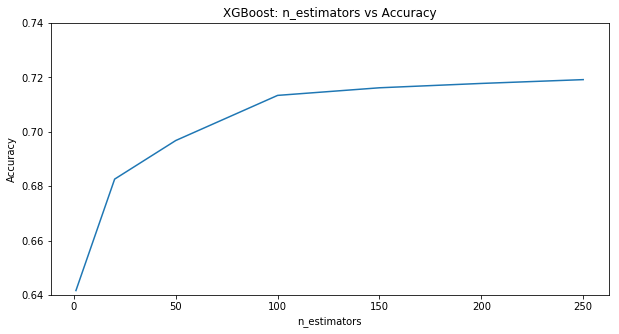

In [49]:
# plot
plt.figure(figsize=((10,5)))
n_estimators = (1, 20, 50, 100, 150, 200, 250)
pyplot.errorbar(n_estimators, accuracy)
pyplot.ylim([0.64, 0.74])
pyplot.title("XGBoost: n_estimators vs Accuracy")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Accuracy')

Most implementations of gradient boosting are configured by default with a relatively small number of trees, such as hundreds for example.
The general reason is that on most problems, adding more trees beyond a limit does not improve the performance of the model.
The reason is in the way that the boosted tree model is constructed, sequentially where each new tree attempts to model and correct for the errors made by the sequence of previous trees. Quickly, the model reaches a point of diminishing returns.

### Task2
Please complete the code below and try to find the best size of decision trees (max_depth in range from 1 to 9 with step=2)
and plot the results. <br> Any ideas why we've got such result? ^-^

In [32]:
parameters = {
   'classifier__*****': (****)}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

grid_search = GridSearchCV(pipeline, param_grid=***, scoring="accuracy", cv=kfold)
grid_result = ******
    

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
accuracy = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(accuracy, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# plot

plt.figure(figsize=((10,5)))
n_estimators** = (*****)
pyplot.errorbar()
pyplot.title("XGBoost: max_depth vs Accuracy)
pyplot.xlabel('****')
pyplot.ylabel('Accuracy')

[To the table of contents](#Table-of-Contents)